<a href="https://colab.research.google.com/github/obov/mnist/blob/main/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [1]:
'''
HYPER PARAMETERS
'''
LEARNING_RATE = 0.001
NUMBER_OF_EPOCHS = 50
BATCH_SIZE = 256
DATA_SET_NAME = 'CIFAR10'
ACTIVATION_FUNCTION = 'LeakyReLU'


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [3]:
transform = transforms.ToTensor()

trainset = getattr(torchvision.datasets, DATA_SET_NAME)(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

Files already downloaded and verified


MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

50000
torch.Size([3, 32, 32]) 6


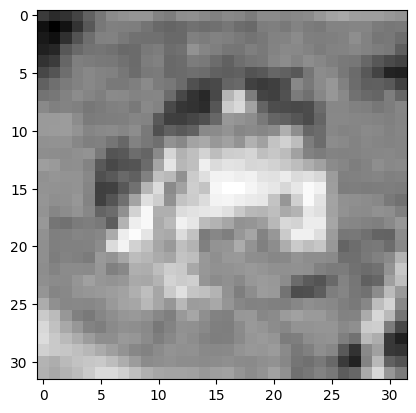

In [4]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

In [5]:
from torch.utils.data import Subset


batch_size = BATCH_SIZE
# 0부터 47999까지는 훈련용, 48000부터 59999까지는 검증용으로 설정
train_indices = list(range(40000))
val_indices = list(range(40000, 50000))

train_dataset = Subset(trainset, train_indices)
val_dataset = Subset(trainset, val_indices)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, 
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [7]:
from torch import nn

output_dim = 10

class Model(nn.Module):
    def __init__(self, input_dim, n_dim, output_dim, activation_function='LeakyReLU', dropout_prob=0.0):
        super().__init__()
        
        # 레이어 정의
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, output_dim)

        # 활성화 함수 설정
        self.act = getattr(nn, activation_function)()
        
        # 드롭아웃 레이어 (dropout_prob이 0이면 드롭아웃이 적용되지 않음)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # 입력을 1D 벡터로 Flatten
        
        # 레이어 1 -> 활성화 함수 -> 드롭아웃
        x = self.act(self.layer1(x))
        x = self.dropout(x)
        
        # 레이어 2 -> 활성화 함수 -> 드롭아웃
        x = self.act(self.layer2(x))
        x = self.dropout(x)
        
        # 마지막 레이어 (출력 레이어)
        x = self.layer3(x)  # 마지막 레이어에서는 활성화 함수 필요 없음
        return x
    
input_dim = 3 * 32 * 32  # 32x32 크기의 3채널(RGB) 이미지를 Flatten한 크기

device = torch.device("mps")

model_leaky_ReLU_plot1 = Model(input_dim, 1024, output_dim).to(device) # plot1
model_leaky_ReLU_plot2 = Model(input_dim, 1024, output_dim).to(device) # plot2
model_sigmoid = Model(input_dim, 1024, output_dim, 'Sigmoid').to(device) # plot2
model_leaky_ReLU_dropout = Model(input_dim, 1024, output_dim, 'LeakyReLU', 0.1).to(device) # plot3

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [8]:
from torch.optim import SGD,Adam

lr = LEARNING_RATE

optimizer_sgd = SGD(model_leaky_ReLU_plot1.parameters(), lr=lr) # plot1
optimizer_adam_plot1 = Adam(model_leaky_ReLU_plot1.parameters(), lr=lr) # plot1
optimizer_adam_plot2 = Adam(model_leaky_ReLU_plot2.parameters(), lr=lr) # plot2
optimizer_adam_sigmoid = Adam(model_sigmoid.parameters(), lr=lr) # plot2
optimizer_dropout = Adam(model_leaky_ReLU_dropout.parameters(), lr=lr) # plot3


이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [9]:
n_epochs = NUMBER_OF_EPOCHS

import matplotlib.pyplot as plt
from tabulate import tabulate
CEL = nn.CrossEntropyLoss()
train_accuracies = []
val_accuracies = []

device='mps'

def train_and_validate(model, optimizer):
    CEL = nn.CrossEntropyLoss()
    train_accuracies = []
    val_accuracies = []

    def accuracy(model, dataloader):
        cnt = 0
        acc = 0
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)
            
            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

        return acc / cnt

    for epoch in range(n_epochs):
        model.train()  # 훈련 모드로 전환
        total_loss = 0.0
        
        # 훈련 루프
        for data in train_loader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            preds = model(inputs)
            loss = CEL(preds, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # 훈련 정확도
        train_accuracy = accuracy(model, train_loader)
        train_accuracies.append(train_accuracy)
        
        # 검증 루프
        model.eval()  # 검증 모드로 전환
        val_loss = 0.0
        with torch.no_grad():  # 검증할 때는 no_grad()를 사용하여 파라미터 업데이트를 하지 않음
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                
                preds = model(inputs)
                loss = CEL(preds, labels)
                val_loss += loss.item()

        # 검증 정확도
        val_accuracy = accuracy(model, val_loader)
        val_accuracies.append(val_accuracy)
        # Epoch이 끝난 후 테이블로 결과 출력
        table = [["___________", "_______Loss___", "___Accuracy___"],
                 ["__Train__", f"{total_loss/2:.2f}  ", f"{train_accuracy:.2%}"],
                 ["Validate", f"{val_loss*2:.2f}  ", f"{val_accuracy:.2%}"]]
        
        print(f"\nEpoch {epoch+1:3d}")
        print(tabulate(table, headers="firstrow", tablefmt="plain", stralign="center"))
    
    return train_accuracies, val_accuracies

In [10]:
import numpy as np
def plot_acc(train_accs, test_accs, label1='train', label2='validate'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

In [11]:
# PLOT1
sgd_train_accuracies, _ = train_and_validate(model_leaky_ReLU_plot1, optimizer_sgd)
adam_train_accuracies, _ = train_and_validate(model_leaky_ReLU_plot1, optimizer_adam_plot1)


Epoch   1
 ___________     _______Loss___   ___Accuracy___
  __Train__              180.55       12.77%
  Validate               183.6        13.13%

Epoch   2
 ___________     _______Loss___   ___Accuracy___
  __Train__              179.86       12.01%
  Validate               182.97       12.29%

Epoch   3
 ___________     _______Loss___   ___Accuracy___
  __Train__              179.28       12.19%
  Validate               182.4        12.52%

Epoch   4
 ___________     _______Loss___   ___Accuracy___
  __Train__              178.72       13.88%
  Validate               181.82       14.01%

Epoch   5
 ___________     _______Loss___   ___Accuracy___
  __Train__              178.14       15.69%
  Validate               181.23       15.59%

Epoch   6
 ___________     _______Loss___   ___Accuracy___
  __Train__              177.53       17.51%
  Validate               180.6        17.14%

Epoch   7
 ___________     _______Loss___   ___Accuracy___
  __Train__              176.89       19

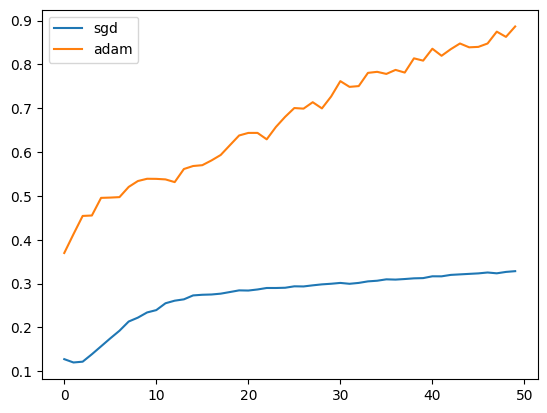

In [12]:
# PLOT1
plot_acc(sgd_train_accuracies,adam_train_accuracies,'sgd','adam')

In [13]:
# PLOT2
leaky_ReLU_train_accuracies, _ = train_and_validate(model_leaky_ReLU_plot2, optimizer_adam_plot2)
sigmoid_train_accuracies, _ = train_and_validate(model_sigmoid, optimizer_adam_sigmoid)


Epoch   1
 ___________     _______Loss___   ___Accuracy___
  __Train__              149.39       37.90%
  Validate               141.8        36.65%

Epoch   2
 ___________     _______Loss___   ___Accuracy___
  __Train__              131.84       38.95%
  Validate               140.63       37.89%

Epoch   3
 ___________     _______Loss___   ___Accuracy___
  __Train__              124.95       42.97%
  Validate               132.2        41.26%

Epoch   4
 ___________     _______Loss___   ___Accuracy___
  __Train__              119.78       43.04%
  Validate               134.76       41.34%

Epoch   5
 ___________     _______Loss___   ___Accuracy___
  __Train__              116.59       47.68%
  Validate               125.57       45.40%

Epoch   6
 ___________     _______Loss___   ___Accuracy___
  __Train__              112.92       48.62%
  Validate               123.99       46.10%

Epoch   7
 ___________     _______Loss___   ___Accuracy___
  __Train__              110.12       49

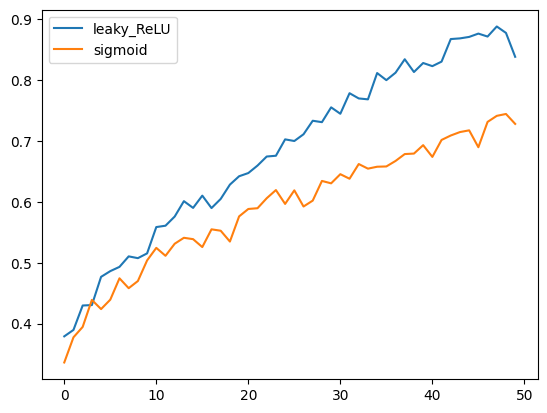

In [14]:
# PLOT2
plot_acc(leaky_ReLU_train_accuracies,sigmoid_train_accuracies,'leaky_ReLU','sigmoid')

In [15]:
# PLOT3
dropout_train_accuracies,dropout_validate_accuracies = train_and_validate(model_leaky_ReLU_dropout, optimizer_dropout)


Epoch   1
 ___________     _______Loss___   ___Accuracy___
  __Train__              151          32.83%
  Validate               150.59       32.26%

Epoch   2
 ___________     _______Loss___   ___Accuracy___
  __Train__              134.13       40.72%
  Validate               135.89       40.22%

Epoch   3
 ___________     _______Loss___   ___Accuracy___
  __Train__              127.27       44.40%
  Validate               127.66       43.93%

Epoch   4
 ___________     _______Loss___   ___Accuracy___
  __Train__              122.9        45.56%
  Validate               125.67       44.24%

Epoch   5
 ___________     _______Loss___   ___Accuracy___
  __Train__              119.58       45.45%
  Validate               125.51       44.33%

Epoch   6
 ___________     _______Loss___   ___Accuracy___
  __Train__              117.68       46.92%
  Validate               122.25       46.24%

Epoch   7
 ___________     _______Loss___   ___Accuracy___
  __Train__              115.26       46

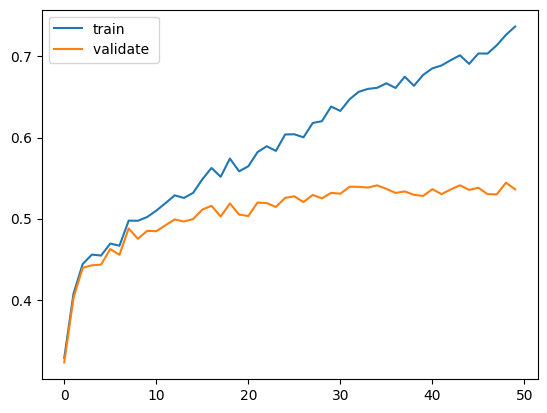

In [16]:
# PLOT3
plot_acc(dropout_train_accuracies,dropout_validate_accuracies,'train','validate ')